# Çoklu Doğrusal Regresyon

### Bir şirketin müşterileri için özel indirimler verdiğini ve bu indirimlerin müşterilerin harcamalarını artırdığını varsayalım. Amacımız, müşterilerin indirim seviyeleri ve bu indirimlerin müşterilerin harcamalarına etkisini analiz etmek olacak.

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [38]:
# veri setini oluşturalım.

np.random.seed(0)
n = 500 # müşteri sayısı

discount_levels = np.random.uniform(low=0, high=1, size=(n,)) # indirim seviyesi (0-1 arası)
ages = np.random.randint(low=18, high=70, size=(n,))
genders = np.random.choice(['Male', 'Female'], size=(n,))
spendings = 5000 + 2000 * discount_levels + 100 * ages + np.random.normal(scale=500, size=(n,)) # müşteri harcamaları

data = pd.DataFrame({
    'Cinsiyet': genders,
    'Yaş': ages,
    'İndirim Seviyesi': discount_levels,
    'Harcamalar': spendings
})
data.head()

,Cinsiyet,Yaş,İndirim Seviyesi,Harcamalar
0,Female,57,0.548814,11792.159567
1,Male,60,0.715189,12266.666039
2,Male,46,0.602763,11171.504493
3,Female,42,0.544883,10014.041776
4,Male,36,0.423655,9071.242742


## Adım 1: Veri Ön İşleme - Analiz

In [39]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Yaş,500.0,42.564000,14.773572,18.000000,30.000000,42.000000,55.000000,69.000000
İndirim Seviyesi,500.0,0.496598,0.291756,0.004695,0.247826,0.486842,0.730746,0.998847
Harcamalar,500.0,10260.141709,1688.928245,6058.780035,9011.729530,10108.892543,11464.630623,14472.623188


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cinsiyet          500 non-null    object 
 1   Yaş               500 non-null    int32  
 2   İndirim Seviyesi  500 non-null    float64
 3   Harcamalar        500 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 13.8+ KB


In [41]:
# eksik değer analizi
data.isnull().sum()

Cinsiyet            0
Yaş                 0
İndirim Seviyesi    0
Harcamalar          0
dtype: int64

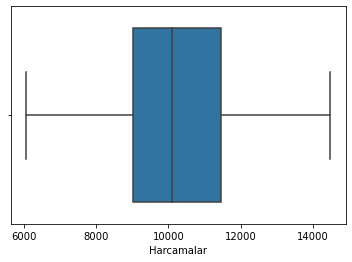

In [42]:
# aykırı gözlem analizi
sns.boxplot(data=data, x='Harcamalar');

In [43]:
# korelasyon matrisini çıkaralım

corr = data.corr()
corr

,Yaş,İndirim Seviyesi,Harcamalar
Yaş,1.000000,0.057363,0.892210
İndirim Seviyesi,0.057363,1.000000,0.394953
Harcamalar,0.892210,0.394953,1.000000


#### harcamalar ve yaş arasında pozitif yönlü güçlü bir korelasyon görülmekte.

<AxesSubplot:>

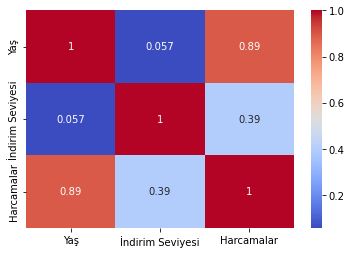

In [44]:
# korelasyon matrisini ısı haritası olarak görselleştirelim.

sns.heatmap(corr, annot=True, cmap='coolwarm')

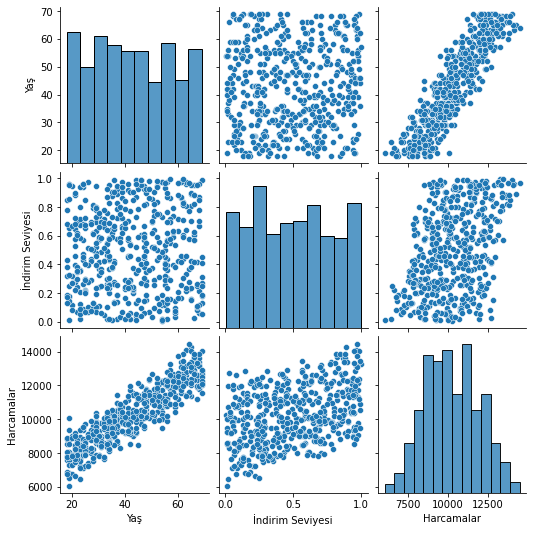

In [45]:
sns.pairplot(data=data);

In [46]:
# kategorik değişken olan cinsiyet değişkenini sayısal değerlere dönüştürelim.
data['Cinsiyet'] = pd.get_dummies(data['Cinsiyet'], drop_first=True)
data.head()

# kadınları 0, erkekleri 1 temsil ediyor!

,Cinsiyet,Yaş,İndirim Seviyesi,Harcamalar
0,0,57,0.548814,11792.159567
1,1,60,0.715189,12266.666039
2,1,46,0.602763,11171.504493
3,0,42,0.544883,10014.041776
4,1,36,0.423655,9071.242742


#### buraya kadar veri setini oluşturduk. veri setinde eksik ve aykırı gözlem analizi yaptık. değişkenlerin aralarındaki korelasyon bağlantılarını görselleştirdik. Kategorik değişkeni sayısal değişkene çevirdik. Şimdi ise modelimizi oluşturabiliriz.

In [47]:
# bağımlı ve bağımsız değişkenleri oluşturalım.

X = data[['İndirim Seviyesi', 'Yaş', 'Cinsiyet']]
y = data['Harcamalar']

In [48]:
# eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
# modeli oluşturalım ve eğitelim.
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [50]:
# Tahmin.
y_pred = model.predict(X_test)

In [51]:
# tahminleri gerçek değerlerle karşılaştırarak modelin performansını test edelim.

r2 = r2_score(y_test, y_pred)
print('R-kare değeri: ', r2)

R-kare değeri:  0.8985737017737248


#### r-kare değeri, bağımsız değişkenlerin, bağımlı değişkeni açıklama gücünü ifade eder ve modelin başarısını temsil eder. r-kare değeri, 0 ile 1 arasında değer alır. Modelimizin r-kare değeri 0.89. Bu gayet iyi bir rakamdır fakat hedeflediğimiz başarının hassasiyetine göre bu değeri pozitif yönde arttırmak için model tuning çalışmaları yapabiliriz.

In [52]:
# model tuning
# en iyi random_state değerini bulmaya çalışalım.

random_states = [0, 10, 20, 42, 60, 80, 100]

for element in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'random_state={element} için R-Kare değeri: {r2}')

random_state=0 için R-Kare değeri: 0.8985737017737248
random_state=10 için R-Kare değeri: 0.8980709301406585
random_state=20 için R-Kare değeri: 0.9306445269176561
random_state=42 için R-Kare değeri: 0.9153881997571852
random_state=60 için R-Kare değeri: 0.923183234795181
random_state=80 için R-Kare değeri: 0.9102147017783353
random_state=100 için R-Kare değeri: 0.9324104173813905


In [56]:
# En iyi random_state değeri için modelimizi tekrar yapılandıralım.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = LinearRegression(fit_intercept=True, copy_X = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-kare değeri: ', r2)

R-kare değeri:  0.9324104173813905


#### Görüldüğü üzere, en iyi R-kare sonucunu random_state=100 için aldık. Şimdi ise modelimizi daha çok optimize edebilmek için hiperparametreleri değerlendirelim.

In [57]:
# model tuning

params = {'fit_intercept':[True, False], 'copy_X':[True, False]}
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print (f'En iyi parametreler: {grid_search.best_params_}\nEn iyi skor: {grid_search.best_score_}')

En iyi parametreler: {'copy_X': True, 'fit_intercept': True}
En iyi skor: 0.9025452206645515


In [58]:
# model doğrulama işlemi yapalım.

scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print('Doğrulama Skorları: ', scores)
print('Ortalama Doğrulama Skorları: ', scores.mean())

Doğrulama Skorları:  [0.9297965  0.8926514  0.92597474 0.87710068 0.88720277]
Ortalama Doğrulama Skorları:  0.9025452206645515
